<a href="https://colab.research.google.com/github/parkmicheal1114/Python_Quest/blob/main/DLthon/Dog_and_Cat_EfficientNET_TEST_fine_block4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import sys
import tensorflow as tf
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import zipfile

zip_paths = ['/content/drive/MyDrive/Colab Notebooks/study_dataset/dogs-vs-cats/train.zip' , '/content/drive/MyDrive/Colab Notebooks/study_dataset/dogs-vs-cats/test1.zip']  # 압축 파일의 경로와 파일명
extract_dir = './content/dogs-vs-cats/'  # 압축 해제할 폴더의 경로와 이름

for zip_path in zip_paths:
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

In [5]:
# train 폴더 확인
train_folder_path = './content/dogs-vs-cats/train'

train_file_names = os.listdir(train_folder_path)
print("train file name" , train_file_names[:5] )
print("train file numbers" , len(train_file_names))

train file name ['cat.10600.jpg', 'cat.6545.jpg', 'cat.9254.jpg', 'dog.7384.jpg', 'cat.2704.jpg']
train file numbers 25000


In [6]:
# test 폴더 확인
test_folder_path = './content/dogs-vs-cats/test1'

test_file_names = os.listdir(test_folder_path)
print("test file name" , test_file_names[:5] )
print("test file numbers" , len(test_file_names))

test file name ['4816.jpg', '11279.jpg', '10006.jpg', '3756.jpg', '7137.jpg']
test file numbers 12500


In [7]:
# Train dataframe

targets = []
full_paths = []
train_cats_dir = []
train_dogs_dir = []


# Target setting
for file_name in train_file_names:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(train_folder_path, file_name)

    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)

    full_paths.append(full_path)
    targets.append(target)


df_train = pd.DataFrame()
df_train['image_path'] = full_paths
df_train['target'] = targets

In [8]:
# Test Data
full_paths = []
file_names = []

for file_name in test_file_names:
    full_path = os.path.join(test_folder_path, file_name)

    file_names.append(file_name)
    full_paths.append(full_path)


df_test = pd.DataFrame()
df_test['image_path'] = full_paths
df_test['filename'] = file_names

In [9]:
train_data , val_data = train_test_split(df_train, test_size=0.2, random_state=123)

In [10]:
# 테스트 parameter Initialization
batch_size = 64
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [11]:
# DataGenrator 를 사용해서 Train , Val , Test data 를 생성 하도록 한다.
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     preprocessing_function = None)

train_data_gen = image_gen_train.flow_from_dataframe(batch_size = batch_size,
                                                     dataframe = train_data,
                                                     x_col = 'image_path',
                                                     y_col = 'target',
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)

val_data_gen = val_datagen.flow_from_dataframe(batch_size = batch_size,
                                                     dataframe = val_data,
                                                     x_col = 'image_path',
                                                     y_col = 'target',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [12]:
# callback 선언.
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min')

callbacks = [early_stopping, reduce_lr]

In [14]:
from keras.applications import EfficientNetB3
from keras import models, layers


# EfficientNetB3 모델 불러오기
efficientnetB3 = EfficientNetB3(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), include_top=False, weights="imagenet")

# freeze_index 설정하기
freeze_index = 118 # block4 레이어의 인덱스

# freeze_index 이전의 층은 고정하고, 이후의 층은 학습 가능하게 설정하기
for layer in efficientnetB3.layers[:freeze_index]:
    layer.trainable = False
for layer in efficientnetB3.layers[freeze_index:]:
    layer.trainable = True

# # 배치 정규화 레이어는 자동 조정 적용하기
# for layer in efficientnetB3.layers:
#     if isinstance(layer, BatchNormalization):
#         layer.trainable = True

# FC Layer 추가하기
model = models.Sequential()
model.add(efficientnetB3)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

history = model.fit(
  train_data_gen,
  steps_per_epoch= train_data.shape[0]/batch_size,
  validation_steps= val_data.shape[0]/batch_size,
  batch_size = batch_size,
  epochs=epochs,
  callbacks = callbacks,
  validation_data= val_data_gen)

Epoch 1/10
312/312 [==============================] - 537s 2s/step - loss: 0.4261 - accuracy: 0.8069 - val_loss: 0.2667 - val_accuracy: 0.8798 - lr: 1.0000e-04
Epoch 2/10
312/312 [==============================] - 460s 1s/step - loss: 0.2425 - accuracy: 0.8905 - val_loss: 0.1536 - val_accuracy: 0.9430 - lr: 1.0000e-04
Epoch 3/10
312/312 [==============================] - 458s 1s/step - loss: 0.1833 - accuracy: 0.9207 - val_loss: 0.1404 - val_accuracy: 0.9478 - lr: 1.0000e-04
Epoch 4/10
312/312 [==============================] - 453s 1s/step - loss: 0.1440 - accuracy: 0.9390 - val_loss: 0.1216 - val_accuracy: 0.9584 - lr: 1.0000e-04
Epoch 5/10
312/312 [==============================] - 449s 1s/step - loss: 0.1169 - accuracy: 0.9510 - val_loss: 0.1277 - val_accuracy: 0.9590 - lr: 1.0000e-04
Epoch 6/10
312/312 [==============================] - 448s 1s/step - loss: 0.1003 - accuracy: 0.9588 - val_loss: 0.1275 - val_accuracy: 0.9620 - lr: 1.0000e-04
Epoch 7/10
313/312 [====================

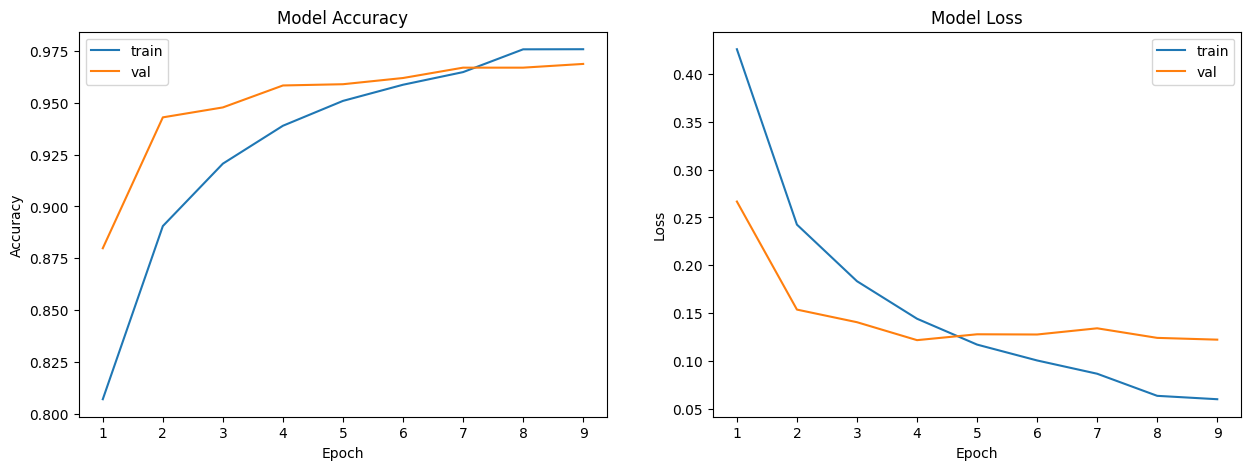

In [15]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')

    axs[0].legend(['train', 'val'], loc='best')

    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')

    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

In [16]:
#테스트 데이터처리.
test_datagen = ImageDataGenerator(rescale=1./255)

test_data_gen = test_datagen.flow_from_dataframe(batch_size = batch_size,
                                                     dataframe = df_test,
                                                     x_col = 'image_path',
                                                     y_col = 'target',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)

Found 12500 validated image filenames.


In [17]:
# 모델 예측하기
pred = model.predict(test_data_gen)

# 임계값 적용하기
df_test['pred']  = pred

196/196 [==============================] - 76s 376ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

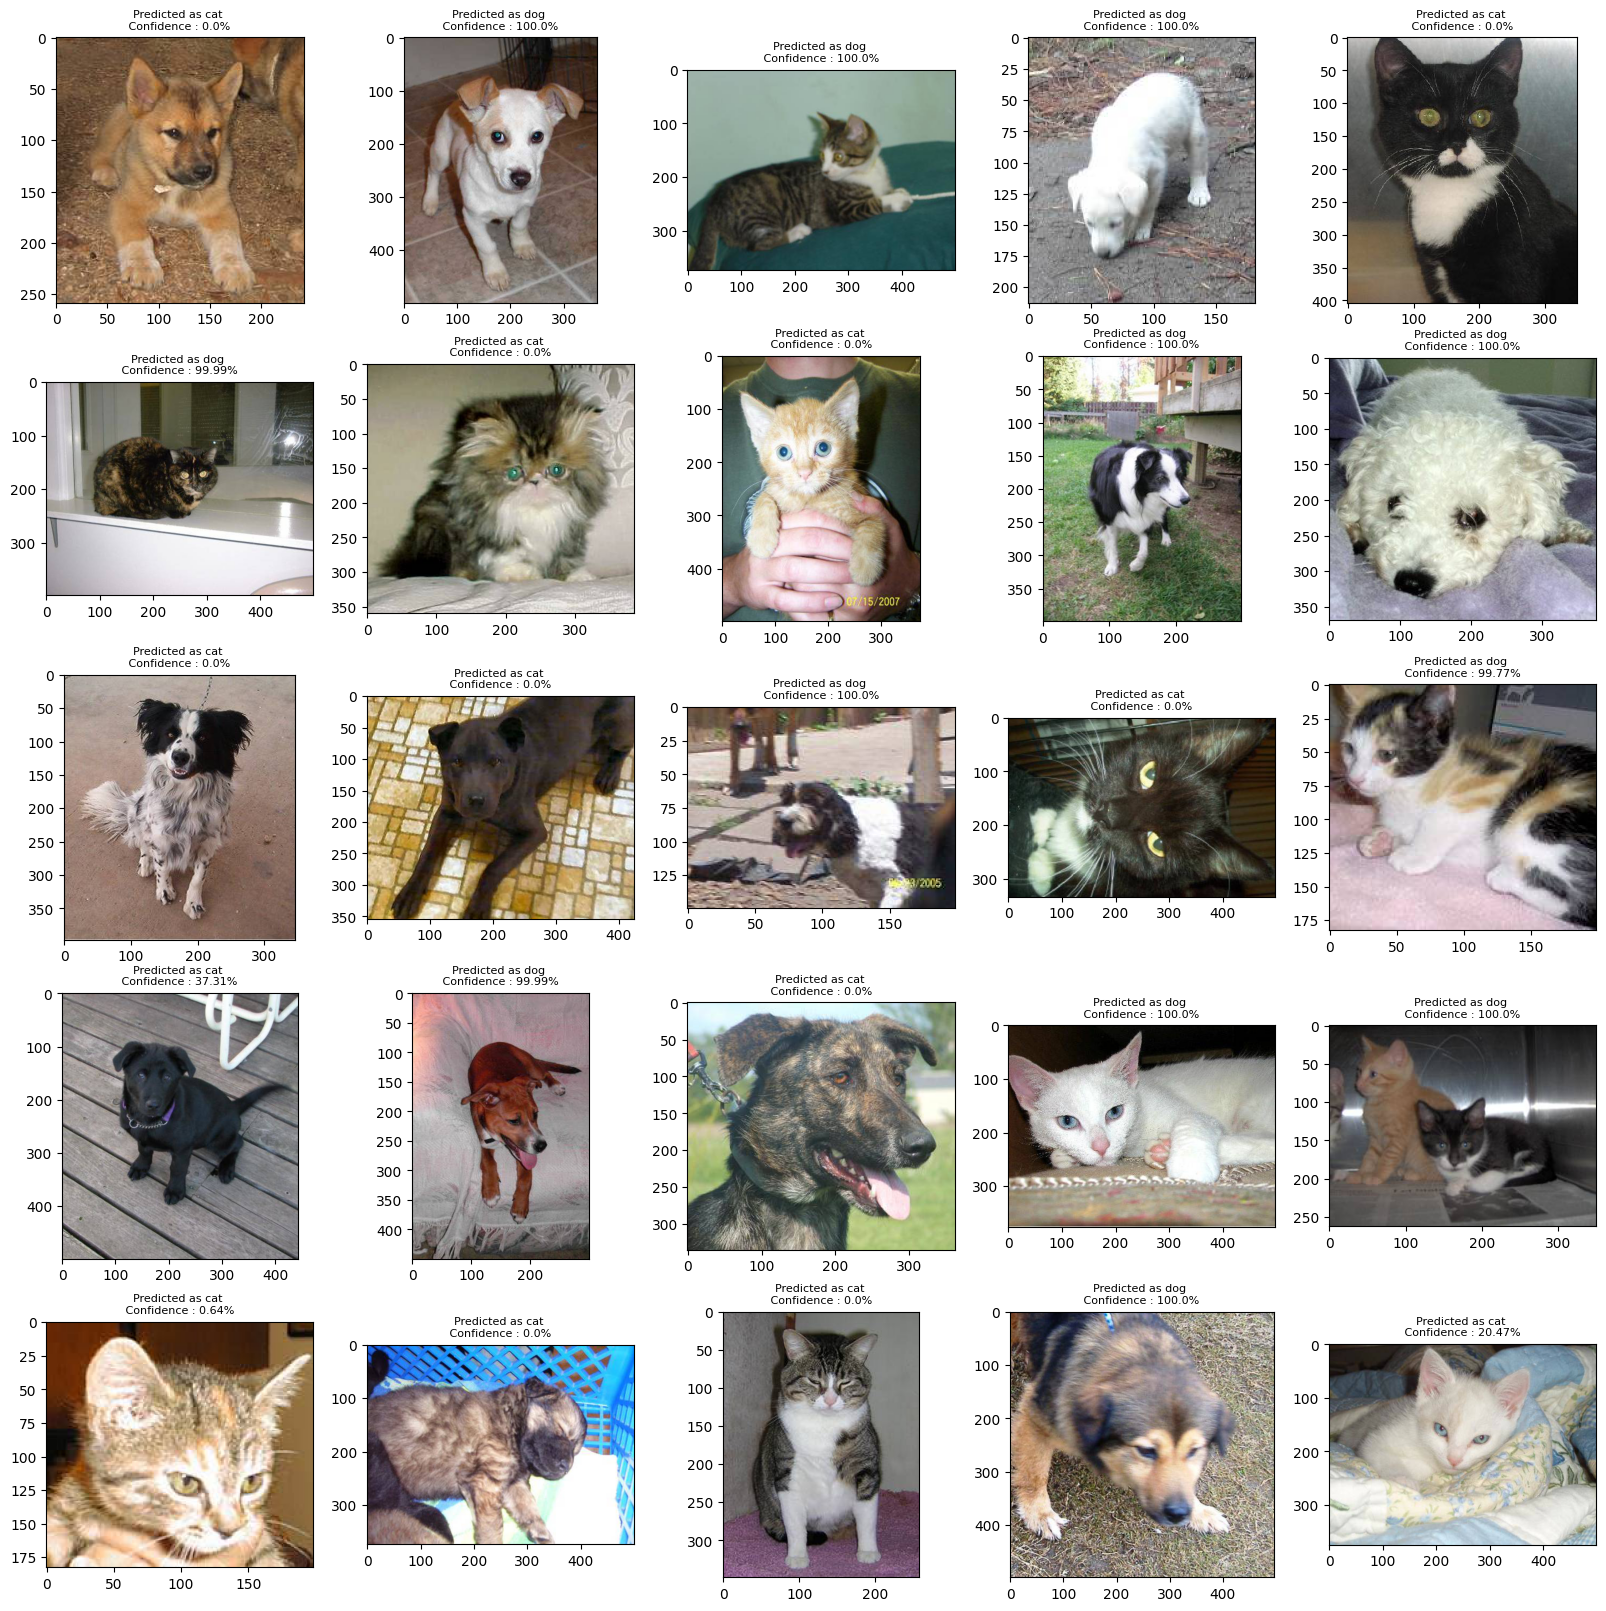

In [18]:
from PIL import Image
predictions = (pred > 0.5).astype(int)
# test 데이터 평가.
fig = plt.figure(1, figsize=(20, 20))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Image.open(df_test.image_path[i]))
    plt.title(f"Predicted as {'dog' if predictions[i] == 1 else 'cat'} \n Confidence : {round(100*(np.max(pred[i])), 2)}% ", fontsize=8)

plt.tight_layout
plt.show

In [19]:
df_submission = df_test.copy()
df_submission['id'] = df_submission['filename'].str.split('.').str[0]
df_submission['label'] = df_submission['pred']

In [21]:
df_submission.drop(['filename', 'image_path','pred'], axis=1, inplace=True)
df_submission.head()

,id,label
0,4816,3.949486e-06
1,11279,9.999998e-01
2,10006,1.000000e+00
3,3756,9.999996e-01
4,7137,7.810577e-19


In [27]:
df_submission.sort_values(by=['id'], ascending=[True], inplace=True)

,id,label
3900,1,9.174687e-14
10479,10,1.000000e+00
7518,100,9.999963e-01
4934,1000,2.892669e-11
6770,10000,9.998121e-01
...,...,...
5303,9995,9.966308e-01
8812,9996,9.311507e-01
8012,9997,1.000000e+00
3781,9998,9.983512e-01


In [29]:
df_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/study_dataset/dogs-vs-cats/submission4.csv' , index=False)